# Aim
* Understand the core mechanics of neural network training
* Learn how gradient descent works in practice
* Gain hands-on experience with both manual and framework-based implementations

# Neural Network Architectures
* Neural networks are modeled as collections of neurons that are connected in an acyclic graph.
* (Typically) Neurons are organized into distinct layers.
    * Neurons between adjacent layers are fully pairwise connected.
    * Neurons within a single layer don't share connections.
* Layer Types: Input Layer, Hidden Layer, and Output Layer.

Note: Neural Networks are also referred to as Artificial Neural Networks (ANN) or Multi-Layer Perceptrons (MLP).

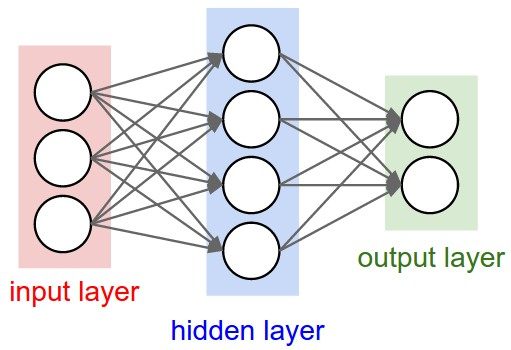

In [260]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH_NEURON = "/Users/sunil/Yashvi/img/neural_net_2layer.jpeg"
Image(filename = PATH_NEURON )

Note: Number of parameters to be learned is used as a proxy for the size of the neural network.

Above is an example of a 2-layer neural network:
* The input layer is not counted as a layer.
* The network has one hidden layer and one output layer.
* It takes 3 inputs and results in 2 outputs.
* The hidden layer has 4 neurons which take 3 inputs and produce 2 outputs.
* Size of the network:
    * Synapse / Weight:
        * Hidden Layer: 4 * 3 = 12
        * Output Layer: 2 * 4 = 8
    * Bias:
        * Hidden Layer (4) + Output Layer (2)
    * Total: 26

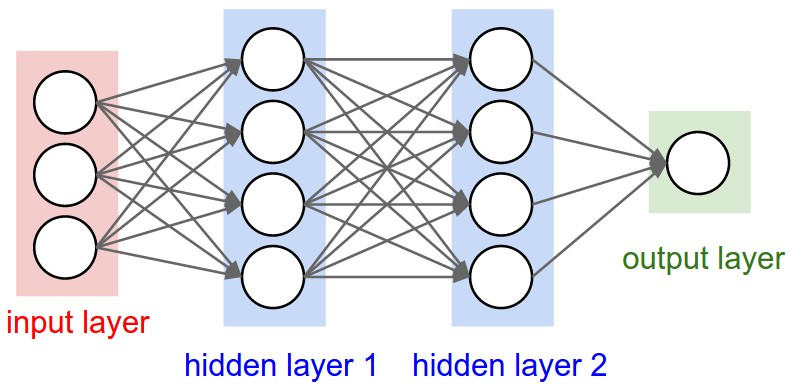

In [261]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH_NEURON = "/Users/sunil/Yashvi/img/neural_net_3layer.jpeg"
Image(filename = PATH_NEURON )

Above is an example of a 3-layer neural network:
* The network has two hidden layers and one output layer.
* It takes 3 inputs and results in 1 output.
* Hidden layers have 4 neurons.
* Hidden layer 1 takes 3 inputs and produces 4 outputs.
* Hidden layer 2 takes 4 inputs and produces 1 output.
* Size of the network:
    * Synapse / Weight:
        * Hidden Layer 1: 4 * 3 = 12
        * Hidden Layer 2: 4 * 4 = 16
        * Output layer: 1 * 4 = 4
    * Bias:
        * Hidden layers 1 and 2 (8) + Output layer (1)
    * Total: 41

Typically, the output layer of a neural network will not have an activation function.


# Nueron Implementation

In [262]:
# A Value object represents a variable in a computation and tracks two key pieces of information:
# 1. The current value of the variable
# 2. How this variable affects the final output (its gradient)

from graphviz import Digraph

from graphviz import Digraph

import numpy as np

class Value:
    def __init__(self, data, label="", prev=[], op=""):
        self.data = data
        self.grad = 0
        self.label = label
        self.prev = prev
        self._backwards = lambda: None
        self.op = op

    def backwards(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backwards()

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, prev=[self, other], op="+")

        def backwards():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backwards = backwards
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Exponent must be a scalar"
        out = Value(self.data ** other, prev=[self], op=f"**{other}")
        def backwards():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backwards = backwards
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def __truediv__(self, other):
        return self * other**(-1)

    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, prev=[self, other], op="*")
        def backwards():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backwards = backwards
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        tanh_value = (np.exp(self.data) - np.exp(-1 * self.data)) / (np.exp(self.data) + np.exp(-1 * self.data))
        out = Value(tanh_value , prev=[self], op="tanh")
        def backwards():
            self.grad += (1 - tanh_value ** 2) * out.grad
        out._backwards = backwards
        return out
    
    def exp(self):
        out = Value(np.exp(self.data), prev=[self], op="exp")
        def backwards():
            self.grad += np.exp(self.data) * out.grad
        out._backwards = backwards
        return out
        
    def __repr__(self):
        return f"Value(label={self.label}, data={self.data}, grad={self.grad})"
    
    def _build(self):
        """builds a set of all nodes and edges in a graph"""
        nodes, edges = set(), set()
        
        def build(v):
            if v not in nodes:
                nodes.add(v)
                for child in v.prev:
                    edges.add((child, v))
                    build(child)
        build(self)
        return nodes, edges
    
    def draw_dot(self):
        """Creates a visualization of the computation graph"""
        dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
        
        nodes, edges = self._build()
        
        # Add all nodes to graph
        for n in nodes:
            uid = str(id(n))
            # Create a node label with data and optional label
            node_label = f"data {n.data:.4f}"
            if n.label:
                node_label += f" | label {n.label}"
                
            if n.grad:
                node_label += f" | grad {n.grad}"
            
            # Add the node as a box
            dot.node(name=uid, 
                    label=node_label,
                    shape='record')
            
            # If it's an operation result, add the operation node
            if n.op:
                op_id = uid + n.op
                dot.node(name=op_id, label=n.op, shape='circle')
                dot.edge(op_id, uid)
        
        # Add edges between nodes
        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2.op)
        
        return dot

In [263]:
x = [2.0, 3.0]

import random
class Neuron:
    def __init__(self, nin):
        self.w = [ Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    def __call__(self, x):
        n = sum((xi*wi for xi, wi in zip(x, self.w)), self.b)
        return n.tanh()
    def parameters(self):
        return self.w + [self.b]
    
n = Neuron(2)
n([1, 2])

Value(label=, data=-0.835815950455413, grad=0)

# Layer Implementaiton

In [264]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]

        return out if len(out) > 1 else out[0] # Return a single value if there's only one neuron
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
l = Layer(2, 3)
l([1, 2])


[Value(label=, data=-0.991444441273336, grad=0),
 Value(label=, data=-0.46651842801616134, grad=0),
 Value(label=, data=0.8770355508171394, grad=0)]

# MLP Implementation

In [265]:
class MLP:
    def __init__(self, nin, layers):
        sz = [nin] + layers
        print(sz)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(layers))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

[3, 4, 4, 1]


Value(label=, data=-0.7922667678501193, grad=0)

# Optimization using Gradient Descent

Aim : To train a 3-layer neural network using gradient descent to predict outputs (`ys`) for given input vectors (`xs`) by iteratively adjusting network weights to minimize prediction error.

## Training Data Setup 

* Input vectors (xs): 4 samples, each with 3 features
* Target outputs (ys): 1.0 or -1.0

In [275]:
xs = [ 
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

## Network architecture 

* 3 layers 
* 3 → 4 → 4 → 1 (input → hidden1 → hidden2 → output) 

In [276]:
mlp = MLP(3, [4, 4, 1])

[3, 4, 4, 1]


## Training Loop Components 

### Forward Pass 
* Generates predictions for each input vector 
* Passes inputs through all network layers
* Uses tanh activation function for non-linearity 

### Gradient Reset 

* Clears previous gradients before backpropagation
* Prevents gradient accumulation across iterations

## Loss Calculation 
* Uses Mean Squared Error (MSE) loss function
* Measures the difference between predictions and actual values
* Squared differences prevent negative errors from canceling positive ones 

## Backpropagation

* Computes gradients of loss with respect to all parameters
* Uses chain rule to propagate gradients backward through the network
* Updates gradient values for each parameter

## Parameter Update

* Implements gradient descent update rule: θ = θ - α∇θ
* Learning rate (α) = 0.01
* Adjusts weights and biases in the direction that reduces loss


In [277]:
Loss = []

for i in range(100000):

    # Forward pass
    ypred = [mlp(x) for x in xs] 

    for p in mlp.parameters():
        p.grad = 0
    
    # Loss calculation
    loss = sum((yi - ypi) ** 2 for yi, ypi in zip(ys, ypred)) ** 0.5

    # Backward pass / Backpropagation
    loss.backwards()
    # Parameter Update
    for p in mlp.parameters():
        p.data -= 0.01 * p.grad

    Loss.append(loss.data)
loss.data

0.00012650198305922512

# Predictive outputs and loss 
From optimization, we achieved a loss of 0.00012650198305922512. Iterating more might improve this loss, but for this exercise, this should be sufficient.

Below shows predicted vs actual output labels.

In [278]:
for yi, yp in zip(ys, ypred):
    print(yi, yp.data)

1.0 0.9999355821855846
-1.0 -0.999979168368335
-1.0 -0.999912615905981
1.0 0.9999384926009449


Below plot shows how loss changes with the iteration.

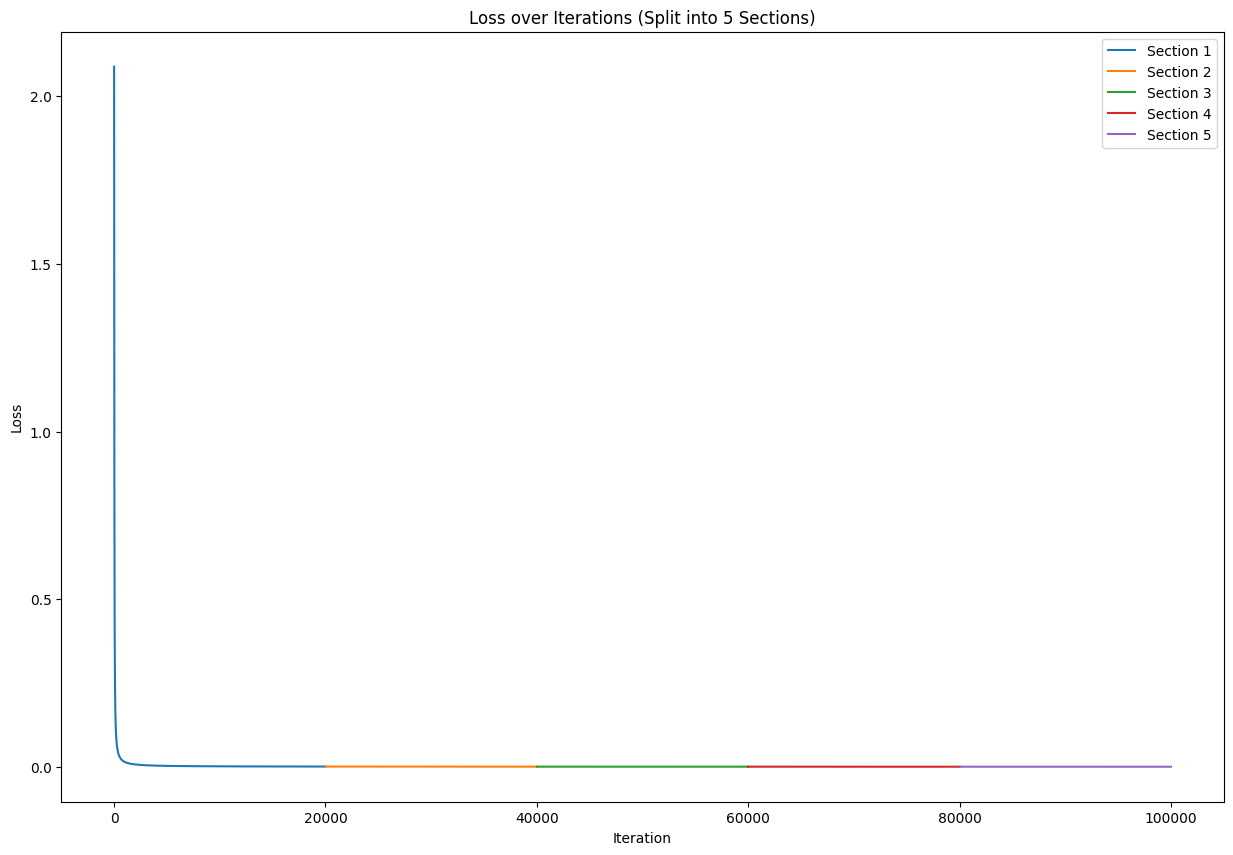

In [279]:
import matplotlib.pyplot as plt

# Split the Loss into 5 sections
num_sections = 5
section_length = len(Loss) // num_sections

# Plot each section
plt.figure(figsize=(15, 10))
for i in range(num_sections):
    start_idx = i * section_length
    end_idx = (i + 1) * section_length if i != num_sections - 1 else len(Loss)
    plt.plot(range(start_idx, end_idx), Loss[start_idx:end_idx], label=f'Section {i+1}')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations (Split into 5 Sections)')
plt.legend()
plt.show()

# Implementing optimization using PyTorch

Epoch [10000/100000], Loss: 8.206768598029157e-12
Epoch [20000/100000], Loss: 6.398437335519702e-12
Epoch [30000/100000], Loss: 5.4143356464919634e-12
Epoch [40000/100000], Loss: 5.261568958303542e-12
Epoch [50000/100000], Loss: 5.261568958303542e-12
Epoch [60000/100000], Loss: 5.261568958303542e-12
Epoch [70000/100000], Loss: 5.261568958303542e-12
Epoch [80000/100000], Loss: 5.261568958303542e-12
Epoch [90000/100000], Loss: 5.261568958303542e-12
Epoch [100000/100000], Loss: 5.261568958303542e-12


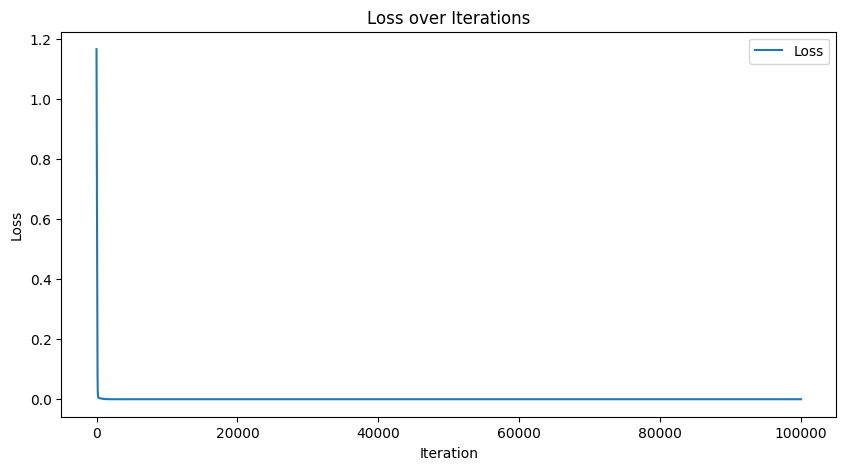


Final Predictions:
[ 1.0000027 -0.9999995 -1.0000007  0.9999964]

Expected Values:
[ 1. -1. -1.  1.]


In [282]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the same training data
xs = torch.tensor([
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
], dtype=torch.float32)

ys = torch.tensor([1.0, -1.0, -1.0, 1.0], dtype=torch.float32).reshape(-1, 1)

# Create the network directly using nn.Sequential
model = nn.Sequential(
    nn.Linear(3, 4),  # Input layer: 3 inputs -> 4 neurons
    nn.Tanh(),
    nn.Linear(4, 4),  # Hidden layer: 4 neurons -> 4 neurons
    nn.Tanh(),
    nn.Linear(4, 1)   # Output layer: 4 neurons -> 1 output
)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
losses = []
num_epochs = 100000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(xs)
    loss = criterion(outputs, ys)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 10000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Plot the loss over iterations
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), losses, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.legend()
plt.show()

# Print final predictions
with torch.no_grad():
    predictions = model(xs)
    print("\nFinal Predictions:")
    print(predictions.numpy().flatten())
    print("\nExpected Values:")
    print(ys.numpy().flatten())